In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from scipy import stats

# Table of Contents
- [Q0. Explore the Dataset](#Q0.ExploretheDataset)
    - [Loading & Preliminary Exploration](#Loading&PreliminaryExploration)
    - [Data Cleaning & Exploration](#Data-Cleaning&Exploration)
      - [Outliers, Impossibilities & General Notes](#Outliers,Impossibilities&GeneralNotes)
      - [Missing Values & Distributions](MissingValues&Distributions)
      - [Categorical Features](CategoricalFeatures)
      - [Correlation](Correlation)
- [Q1. Explore the Peak Age of Horses](#Q1.ExplorethePeakAgeofHorses)
- [Q2. Feature Engineering: Rating for each Horse, Jockey and Trainer](#Q2.FeatureEngineering:RatingforeachHorse,JockeyandTrainer)
     - [Horse Rating](#HorseRating)
     - [Jockey Rating](#JockeyRating)
     - [TrainerRating](#TrainerRating)
- [Q3. Predictive Model](#Q3PredictiveModel)
     - [Train-Test Split](#TrainTestSplit)
     - [Model Choice](#ModelChoice)
       - [Horse Level Models](#HorseLevelModels)
       - [Race Level Models](#RaceLevelModels)
       - [Final Decision](#FinalDecision)
     - [T-Fold Rolling Cross-Validation](#CV)
     - [Fitting the Model](#FittingtheModel)
- [Q4. Comparing to the Betting Market & Finding a Strategy](#Q4)
     - [Compare to the Betting Market](#Compare)
        - [Overall Comparison](#Overall)
        - [Comparison by Subsets](#Subsets)
        - [Strategy](#Strategy)

# Q0. Explore the Dataset

In this section we explore the dataset as well as clean and preprocess the data as needed for the future model.

## Loading & Preliminary Exploration

In [6]:
data = pd.read_csv("test_dataset.csv")

In [7]:
print(f"There are {data.shape[0]} many samples")

There are 777549 many samples


In [8]:
data.head()

,date,racecourse_country,racecourse_name,race_time,race_id,race_distance,race_type,race_type_simple,going_clean,n_runners,...,ltp_5min,obs__bsp,obs__racing_post_rating,obs__Place,obs__uposition,obs__is_winner,obs__top_speed,obs__distance_to_winner,obs__pos_prize,obs__completion_time
0,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,...,7.8,9.12,82.0,3,3,0,48.0,2.5,721.50,155.95
1,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,...,5.8,7.00,81.0,2,2,0,47.0,0.5,1443.75,155.61
2,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,...,12.0,9.28,45.0,8,8,0,11.0,23.0,0.00,159.36
3,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,...,34.0,18.00,62.0,6,6,0,28.0,13.0,0.00,157.70
4,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,...,7.6,7.40,77.0,5,5,0,44.0,6.0,0.00,156.53


We take a look at the columns:

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777549 entries, 0 to 777548
Data columns (total 30 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   date                     777549 non-null  object 
 1   racecourse_country       777549 non-null  object 
 2   racecourse_name          777549 non-null  object 
 3   race_time                777549 non-null  object 
 4   race_id                  777549 non-null  int64  
 5   race_distance            777549 non-null  float64
 6   race_type                777549 non-null  object 
 7   race_type_simple         777549 non-null  object 
 8   going_clean              777549 non-null  object 
 9   n_runners                777549 non-null  int64  
 10  horse_id                 777549 non-null  int64  
 11  horse_name               777549 non-null  object 
 12  age                      777549 non-null  int64  
 13  official_rating          573933 non-null  float64
 14  carr

It seems that *official_rating*, *obs__racing_post_rating*, *obs__top_speed* and *obs__completion_time* have missing values. Note that *ltp_5min* does too (but very few).

We check for duplicates:

In [13]:
data.drop_duplicates(inplace=True)
print(f"There were {777549 - data.shape[0]} duplicate rows")

There were 0 duplicate rows


Sort by date and time: 

In [15]:
data["race_datetime"] = data["date"].astype("str") + " " + data["race_time"].astype("str")
data["race_datetime"] = pd.to_datetime(data["race_datetime"], format="%Y-%m-%d %H:%M")
data.drop(["date", "race_time"], axis=1, inplace=True)
data.sort_values(by="race_datetime", inplace=True)

## Data Cleaning & Exploration

### Outliers, Impossibilities & General Notes

Here we look for outliers and decide what to do with them, detect impossible (i.e. erroneous) data and deal with it, and note some general comments.

We should first look at a brief description of the numerical data:

In [20]:
data.drop(["race_id", "horse_id", "trainer_id", "jockey_id"], axis=1).describe()

,race_distance,n_runners,age,official_rating,carried_weight,draw,ltp_5min,obs__bsp,obs__racing_post_rating,obs__uposition,obs__is_winner,obs__top_speed,obs__distance_to_winner,obs__pos_prize,obs__completion_time,race_datetime
count,777549.000000,777549.000000,777549.000000,573933.000000,777549.000000,777549.000000,776013.000000,777549.000000,712937.000000,777549.000000,777549.000000,613980.000000,777549.000000,777549.000000,729807.000000,777549
mean,2576.181522,10.922081,5.111508,84.482016,62.940441,3.749681,57.562299,64.618670,74.780498,5.961040,0.105213,50.133003,13.843247,1648.562300,178.525863,2018-11-09 13:31:23.727481856
min,1000.353600,2.000000,1.000000,1.000000,43.544868,0.000000,1.050000,1.030000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,54.000000,2015-05-01 13:40:00
25%,1409.090400,8.000000,3.000000,65.000000,57.152639,0.000000,7.000000,7.000000,55.000000,3.000000,0.000000,30.000000,2.750000,0.000000,88.530000,2017-01-19 19:30:00
50%,2253.081600,11.000000,5.000000,80.000000,60.327785,2.000000,14.000000,14.500000,73.000000,5.000000,0.000000,48.000000,8.300000,280.000000,133.710000,2018-11-15 14:55:00
75%,3461.918400,13.000000,7.000000,102.000000,69.399633,7.000000,36.000000,37.350000,94.000000,8.000000,0.000000,67.000000,21.800000,962.500000,259.810000,2020-09-26 16:45:00
max,6907.377600,40.000000,18.000000,177.000000,81.193034,37.000000,1000.000000,1001.000000,181.000000,40.000000,1.000000,177.000000,40.000000,921537.500000,614.090000,2022-04-30 20:20:00
std,1262.509887,3.995936,2.318795,25.583146,6.810474,4.408433,148.671556,163.297245,29.183750,3.896173,0.306827,27.501326,13.891333,9359.561244,105.368744,NaN


- We are obviously dealing with an imbalanced dataset (only one horse wins per race). The mean of *obs__is_winner* is $0.105$, so the split is roughly $90-10$.
- The number of runners can change quite a bit, with some races having only $2$ horses.
- Both *ltp_5min* and *obs__bsp* have some row(s) with extreme values ($1000$ and $1001$). The standard deviations also seem unusually high compared to the means. We explore this:

In [22]:
print(f"There are {len(data[data["ltp_5min"]==1000])} many samples with last traded price 5min before equal to exactly 1000.")
print(f"There are {len(data[data["ltp_5min"]==990])} many samples with last traded price 5min before equal to exactly 990.")
print(f"There are {len(data[data["obs__bsp"]==1000])} many samples with Betfair Starting Price equal to exactly 1000.")
print(f"There are {len(data[data["obs__bsp"]==1001])} many samples with Betfair Starting Price equal to exactly 1001.")

There are 10718 many samples with last traded price 5min before equal to exactly 1000.
There are 340 many samples with last traded price 5min before equal to exactly 990.
There are 12759 many samples with Betfair Starting Price equal to exactly 1000.
There are 160 many samples with Betfair Starting Price equal to exactly 1001.


That cannot be a coincidence. They probably indicate missing values. We check the distributions: 

<Axes: >

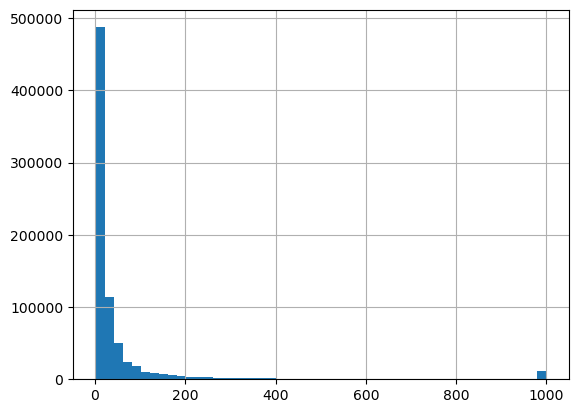

In [24]:
data["ltp_5min"].hist(bins=50)

<Axes: >

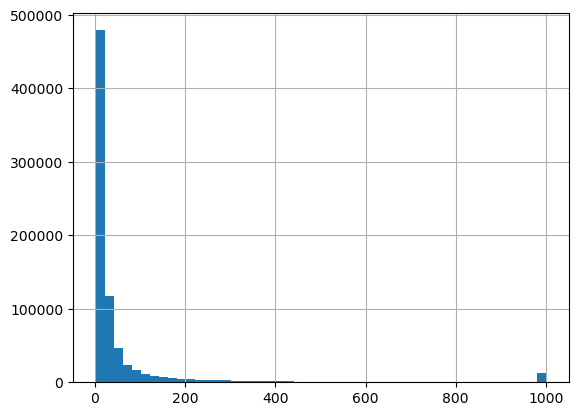

In [25]:
data["obs__bsp"].hist(bins=50)

There do seem to be many outlier (likely erroneous/missing) values, so we fix that via the Interquantile Range method. This is better than just looking at the mean, since the mean can be heavily biased with these extreme outliers. 

In [27]:
# Interquartile range method
def IQR(data, col_name):
    # Q1 and Q3
    q1 = data[col_name].quantile(0.25)
    q3 = data[col_name].quantile(0.75)

    # IQR
    iqr = q3-q1

    # Outlier thresholds
    up = q3 + 1.5*iqr
    down = q1 - 1.5*iqr

    # Transform outliers into NaNs
    data.loc[(data[col_name]>up) | (data[col_name]<down), col_name] = np.nan

In [28]:
IQR(data, "ltp_5min")
IQR(data, "obs__bsp")

Now the distributions look as expected (right tail for underdog horses):

<Axes: >

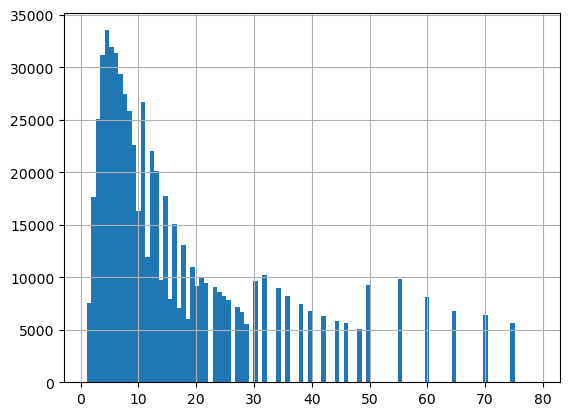

In [30]:
data["ltp_5min"].hist(bins=100)

<Axes: >

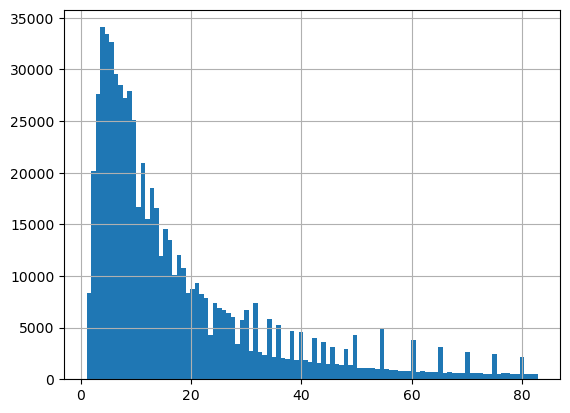

In [31]:
data["obs__bsp"].hist(bins=100)

The distributions do seem very similar, which means market opinion does not tend to change very much in the last $5$ minutes, except for the fact that the values are more spread out in *obs__bsp* than concentrated at "nice" values such as $55,60,65,65,70,75$ like in *ltp_5min*. It seems that bets are "smoothed out" right as the race starts.

- *obs__distance_to_winner* has a maximum value of exactly $40$, which is suspicious. We explore:

<Axes: >

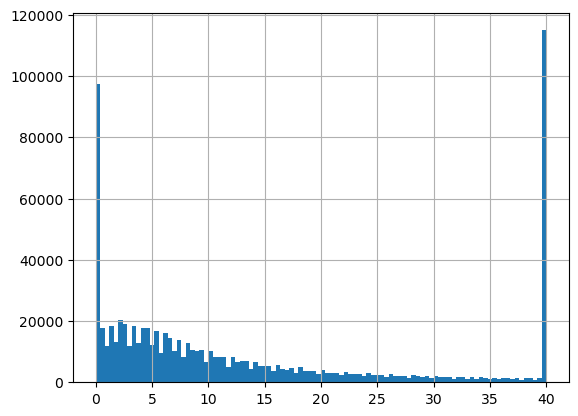

In [34]:
data["obs__distance_to_winner"].hist(bins=100)

This definitely seems unnatural. The spike at $0$ seems normal (each race produces a winner), but it seems $40$ has been used as a cutoff or a representation of "horse did not finish". We want to tidy that up so it does not ruin the numerical feature, but keep the information from the $40$ cases inside a *finish_flag* feature (although of course we will not use it for predictions!):

In [36]:
# Flag for finishing/not being very far behind
data["finish_flag"] = (data["obs__distance_to_winner"] == 40).astype(int)

# Replace the 40s with NaNs
data["obs__distance_to_winner"] = data["obs__distance_to_winner"].where(data["obs__distance_to_winner"] != 40, np.nan)

In [37]:
data["finish_flag"]

0         0
1         0
2         0
3         0
4         0
         ..
777540    0
777539    1
777538    0
777542    0
777548    0
Name: finish_flag, Length: 777549, dtype: int32

Now it looks reasonable:

<Axes: >

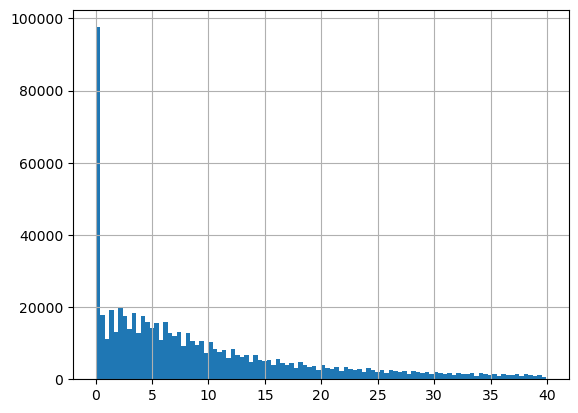

In [39]:
data["obs__distance_to_winner"].hist(bins=100)

- *obs__uposition* and *n_runners* both go up to $40$, meaning there is a race with $40$ horses. This might be an error, considering the maximum *draw* is only $37$. This cannot be explained by missing values, since neither column has any. We explore by considering *obs_Place*, which is the same as *obs__uposition* but with more information (it includes values such as "F" for the horse falling, "UR" for unseated rider, etc.):

In [41]:
# Rows with either obs__uposition or n_runners above 37
over_37 = data.loc[(data["obs__uposition"] > 37) | (data["n_runners"] > 37), ["obs__distance_to_winner", "obs__uposition", "obs__Place", "n_runners", "draw"]]
over_37

,obs__distance_to_winner,obs__uposition,obs__Place,n_runners,draw
98677,NaN,27,PU,39,0
98673,NaN,13,13,39,0
98674,NaN,22,PU,39,0
98672,NaN,20,PU,39,0
98675,NaN,30,F,39,0
...,...,...,...,...,...
769793,22.25,3,3,40,0
769794,NaN,28,UR,40,0
769796,NaN,33,BD,40,0
769795,NaN,34,UR,40,0


It seems that for most of these, *obs__Place* indicates that there was an issue. This explains why most have no distance to winner. But it does not explain why *n_runners* and *obs_uposition* are higher than they could be. Also, all of these rows mysteriously have *draw* $=0$:

In [43]:
# Check if draw is always 0
over_37["draw"].sum()

0

Given that there are so few of these samples and the fact that we cannot rely on their data, we drop them.

In [45]:
data.drop(over_37.index, inplace=True)
data.reset_index(inplace=True, drop=True)

### Missing Values & Distributions

Here we decide what to do with missing values and look at distributions of interest.

We look at missing values per column:

In [49]:
data.isnull().sum()

racecourse_country              0
racecourse_name                 0
race_id                         0
race_distance                   0
race_type                       0
race_type_simple                0
going_clean                     0
n_runners                       0
horse_id                        0
horse_name                      0
age                             0
official_rating            203616
carried_weight                  0
draw                            0
jockey_id                       0
jockey_name                     0
trainer_id                      0
trainer_name                    0
ltp_5min                   107179
obs__bsp                   109828
obs__racing_post_rating     64492
obs__Place                      0
obs__uposition                  0
obs__is_winner                  0
obs__top_speed             163452
obs__distance_to_winner    114064
obs__pos_prize                  0
obs__completion_time        47627
race_datetime                   0
finish_flag   

I would normally substitute these via imputing (either basic mean/median imputing or model-based). The choice of how to do it depends on the distribution of each feature (e.g. if it has a normal distribution or there are very few NaNs then mean imputing should be fine, but for other cases model-based imputing such as a kNN model trained on other features could be better). 
However, in this case this will not be necessary: When answering Q3 below, we end up choosing the XGBoost model (the discussion of why it was chosen is in that section). This model handles NaNs natively really well, so it is not necessary for us to do it this time.

Even though there is no need to impute, it is still interesting to look at some of the distributions we have not seen yet:

<Axes: >

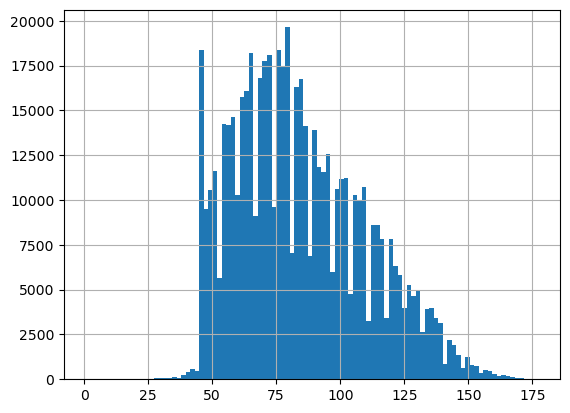

In [52]:
data["official_rating"].hist(bins=100)

The spike at $40$ seems suspicious (maybe the default value given to horses who have not raced before?). In past distributions $40$ seemed to be a placeholder, so it might be the case here too. Since I do not know its cause, I will leave it as it is, but more exploration could be useful.

<Axes: >

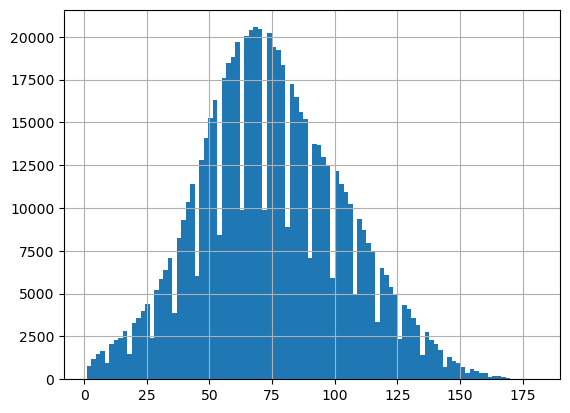

In [54]:
data["obs__racing_post_rating"].hist(bins=100)

This weird shape is probably a product of the way the *obs__racing_post_rating* is computed.

<Axes: >

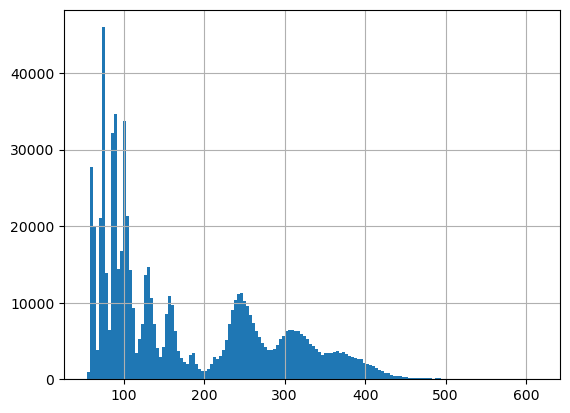

In [56]:
data["obs__completion_time"].hist(bins=150)

The various peaks indicate that the completion time probably varies depending on race type, or maybe that certain race lengths are standard. The peaks on the left are odd. In the interest of time, I will leave it as it is, but further exploration should be done.

### Categorical Features

Here we explore the possible values the categorical features can take, as well as define our strategy for preprocessing each of them for the future model. However, we do not preprocess them yet in order to avoid data leakage from the training set into the test set (we just create the preprocessing functions).

Detect the categorical features:

In [61]:
num_cols = list(data.select_dtypes(include=["int32", "int64", "float64"]).columns)
cat_cols = [col for col in list(data.columns) if col not in num_cols]

In [62]:
print("The categorical features are", cat_cols)

The categorical features are ['racecourse_country', 'racecourse_name', 'race_type', 'race_type_simple', 'going_clean', 'horse_name', 'jockey_name', 'trainer_name', 'obs__Place', 'race_datetime']


Most races happen in GB and all happen in GB or IRE:

In [64]:
data["racecourse_country"].value_counts()

racecourse_country
GB     574699
IRE    202651
Name: count, dtype: int64

We **one-hot encode** the country: We create two columns (one for GB, the other for IRE) with $1$s and $0$s indicating whether the race was done in that country or not. Since only one of those columns gives us all the information, it only makes sense to keep one. So we only create the one for GB:

In [66]:
# Function to one-hot encode the country
def preprocess_country(data):
    country_map = {"GB":1, "IRE":0}
    data["racecourse_country_encoded"] = data["racecourse_country"].map(country_map)

    # Drop old column
    data.drop(["racecourse_country"], axis=1, inplace=True)

All the data is concentrated in only $86$ race courses:

In [68]:
data["racecourse_name"].value_counts()

racecourse_name
Wolverhampton    37511
Kempton          33798
Lingfield        32767
Newcastle        26084
Dundalk          24134
                 ...  
Fakenham          3119
Sligo             3104
Cartmel           3023
Towcester         1551
Laytown            315
Name: count, Length: 86, dtype: int64

One-hot encoding should be avoided here, since don't want to explode the dimension of the feature space. We could **target encode**: replace each racecourse name with the winning rate at the race course. But then we really are just capturing the average amount of horses in races done at that race course. Therefore a more interesting option is **frequency encoding**: replace each race course with how frequent its appearance is. Obviously using only past data to compute this frequency. 

There is also an extra detail at play. When we preprocess a new sample (e.g. from the test set), we will need to compute this frequency from the training data, not the new data. We ensure our function allows us to say whether we are processing a new sample or not with *new_flag*:

In [70]:
# Frquency encode the racecourse name
def preprocess_racecourse(train_data, new_data=None, new_flag=False):
    # Preprocessing for training
    if not new_flag:
        # Order chronologically
        train_data = train_data.sort_values(by="race_datetime").copy()

        # Encode with the past frequency
        freq = train_data.groupby(by="racecourse_name").cumcount()
        train_data["racecourse_name_encoded"] = freq

        # Drop old column
        train_data.drop("racecourse_name", axis=1, inplace=True)

        return train_data
        
    # Preprocess new samples
    else:
        # Order chronologically
        train_data = train_data.sort_values(by="race_datetime").copy()
        new_data = new_data.sort_values(by="race_datetime").copy()

        # Get the historic frequencies from the training data
        freqs = train_data["racecourse_name"].value_counts()

        # Encode with the historic frequencies
        new_data["racecourse_name_encoded"] = new_data["racecourse_name"].map(freqs)

        # If the race course in the new data does not exist in the training data, it will have been replaced
        # by a NaN. We replace that with a 0
        new_data["racecourse_name_encoded"] = new_data["racecourse_name_encoded"].fillna(0)

        # Drop old column
        new_data.drop("racecourse_name", axis=1, inplace=True)

        return new_data     

The two features *race_type* and *race_type_simple* should be explored together. The first distinguishes between Flat (flat ground), Bumper (flat ground but with jumping rules, usually used to introduce young jumping horses), Hurdle (small jumps) and Chase (big jumps). 

The second gives insight into the surface of the flat races. Hurdle and Chase stay the same (same number of samples), but Flat and Bumper are further split into Flat Turf (grass) or Flat AW (all-weather synthetic surfaces).

In [72]:
data["race_type"].value_counts()

race_type
Flat      463683
Hurdle    187572
Chase      96050
Bumper     30045
Name: count, dtype: int64

In [73]:
data["race_type_simple"].value_counts()

race_type_simple
Flat Turf    317096
Hurdle       187572
Flat AW      176632
Chase         96050
Name: count, dtype: int64

We **order encode** these features: We want to capture the relationship between the different values (e.g. Flat and Bumper are closer to each other than to Chase), so we replace the strings with integers that are closer/further away to/from each other.

In [75]:
# Encode the race types with ordered labels  
def preprocess_race_type(data):
    map1 = {"Flat":0, "Bumper":1, "Hurdle":2, "Chase":3}
    map2 = {"Flat Turf":0, "Flat AW":1, "Hurdle":2, "Chase":3}
    
    data["race_type_encoded"] = data["race_type"].map(map1)
    data.drop("race_type", axis=1, inplace=True)

    data["race_type_simple_encoded"] = data["race_type_simple"].map(map2)
    data.drop("race_type_simple", axis=1, inplace=True)

Most races have good and soft ground:

In [77]:
data["going_clean"].value_counts()

going_clean
Good     480118
Soft     143568
Firm      95353
Heavy     58311
Name: count, dtype: int64

Order encoding is a good option for this feature too:

In [79]:
# Encode the condition of the surface with ordered labels 
def preprocess_going(data):
    going_map = {"Soft":0, "Good":1, "Firm":2, "Heavy":3}
    data["going_clean_encoded"] = data["going_clean"].map(going_map)
    data.drop("going_clean", axis=1, inplace=True)

There are many different values for *horse_name*, *trainer_name* and *jockey_name*, obviously. So one-hot encoding is a bad idea (we don't want to explode the dimension of the feature space). Ordered label encoding also makes no sense (there is no ordered relationship between names). 

In [81]:
print(f"There are {data["horse_name"].nunique()} unique horse names")
print(f"There are {data["jockey_name"].nunique()} unique jockey names")
print(f"There are {data["trainer_name"].nunique()} unique trainer names")

There are 77793 unique horse names
There are 2585 unique jockey names
There are 2440 unique trainer names


The goal is to encode them in such a way that the resulting feature is very related to the target (winning or not). We should therefore use target encoding here: replace each name with the proportion of wins with respect to how many times they have run. Of course, we should only use past data to compute this. And we also need to take care of the case where the horse/jockey/trainer has not run before. In that case, we will just set it to the average win rate.

There is also an extra detail at play. When we preprocess a new sample (e.g. from the test set), we will need to compute this average win rate from the training data. We ensure our function allows us to say whether we are processing a new sample or not with *new_flag*:

In [83]:
# Target encode a feature of names called col_name

def preprocess_names(train_data, col_name, new_data=None, new_flag=False):
    # Preprocess for training
    if not new_flag:
        # Order chronologically
        train_data = train_data.sort_values(by="race_datetime").copy()

        # Compute the historic win rates
        # First group by the names
        grouped = train_data.groupby(by=col_name)["obs__is_winner"]
        # Count the past wins and total races
        wins = grouped.cumsum()
        total_races = grouped.cumcount()

        # Edit wins slightly
        wins = wins - train_data["obs__is_winner"] # do not count current row towards the win count (so we subtract it)

        # Encode
        train_data[col_name + "_encoded"] = wins/total_races

        # Drop old column
        train_data.drop(col_name, axis=1, inplace=True)

        return train_data
        

    # Preprocess new samples
    else:
        # Order chronologically
        train_data = train_data.sort_values(by="race_datetime").copy()
        new_data = new_data.sort_values(by="race_datetime").copy()

        # Get the historic win rates from the training data
        historic_win_rates = train_data.groupby(by=col_name)["obs__is_winner"].mean()

        # Encode with the historic win rates
        new_data[col_name + "_encoded"] = new_data[col_name].map(historic_win_rates)

        # If a name from the new samples did not exist in the training data, it will have been replaced by
        # a NaN in the previous step. Since XGBoost handles it natively, it is not an issue. But with a different model we
        # would have to replace that NaN with the global win rate of the training data.

        # Drop old column
        new_data.drop(col_name, axis=1, inplace=True)

        return new_data

Recall that *obs__Place* is the same as *obs__uposition* but it indicates where there was an issue such as the horse falling, rider unseated, etc. We explore that feature here. It seems "PU" (Pulled Up), meaning the jockey stopped the horse during the race, is quite common.:

In [85]:
data["obs__Place"].value_counts().head(10)

obs__Place
1     81929
2     81768
3     81306
4     79422
5     74891
6     67680
7     59035
8     49812
9     40735
PU    32878
Name: count, dtype: int64

### Correlation

Here we explore the Pearson correlation of the numerical variables with the target (*obs__is_winner*), as well as with each other. Note that this only measures linear relationship, but it should be good enough to give us a sense of which features are most important.

In [88]:
correlation_matrix = data[num_cols].drop(["horse_id", "trainer_id", "jockey_id", "race_id"], axis=1).corr()

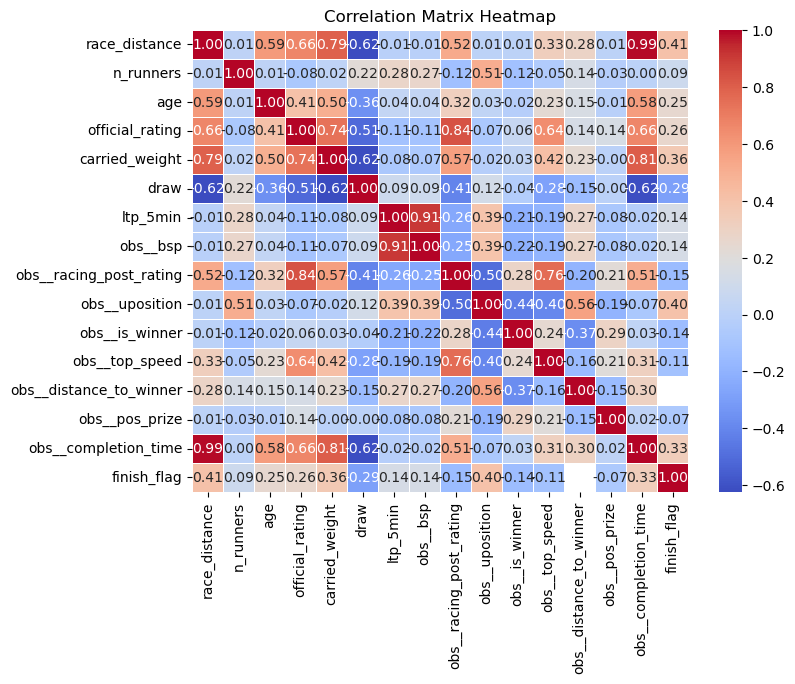

In [89]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

We can see that *obs__is_winner* is highly correlated with obvious things like *obs__uposition*, *obs__distance_to_winner*, *obs__top_speed*, *obs__racing_post_rating*, *ltp_5min* and *obs_bsp*. This was expected, and it also means that these features are good candidates to use to form the scores in Q2 below. 

Worryingly, *official_rating*, *carried_weight* and *age* do not seem to be very linearly correlated with *obs__is_winner*. But it might be that the relationship is nonlinear, so we explore their relationships:

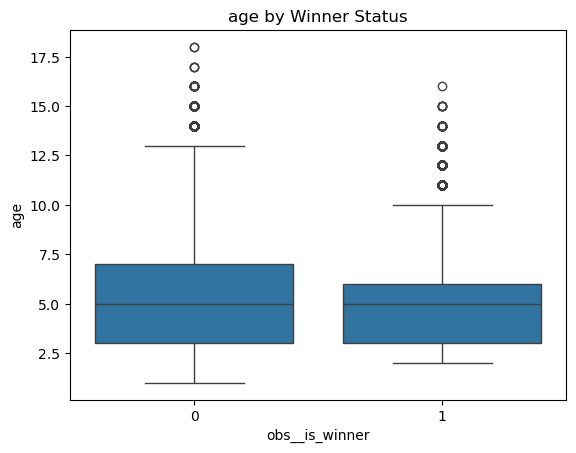

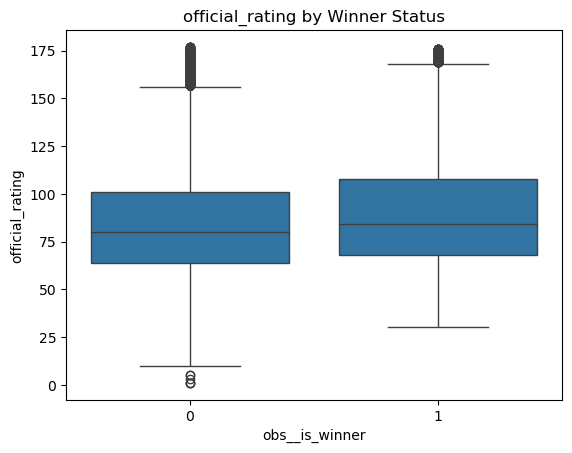

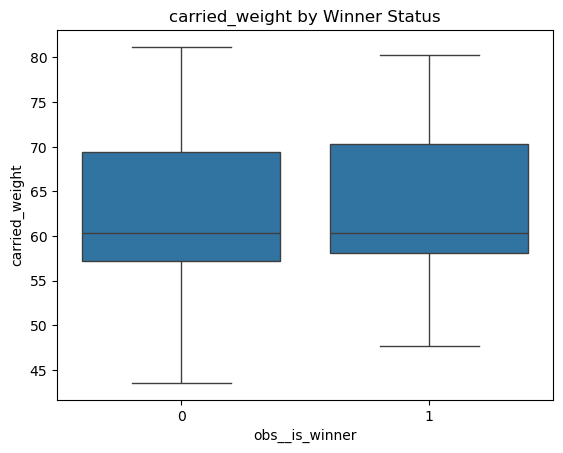

In [91]:
for col in ["age", "official_rating", "carried_weight"]:
    sns.boxplot(x="obs__is_winner", y=col, data=data)
    plt.title(f'{col} by Winner Status')
    plt.show()

There do seem to be clear relationships:
- The median age is the same for winners and non-winners, but it is very clear that the winners are by far younger, sitting between $3$ and $6$ years old.
- The official rating also tends to be higher for winners, getting closer to $100$.
- The weight carried has the least extreme relationship, but we can clearly see that winners tend to have slightly higher carried weight.

# Q1. Explore the Peak Age of Horses

Here we analyse the performance by age grouped by *race_type_simple* and in particular report the peak performance age. We already know what values we can have for this feature:

In [95]:
print(f"These are the unique values for race_type_simple: {data.race_type_simple.unique()}")

These are the unique values for race_type_simple: ['Flat Turf' 'Flat AW' 'Chase' 'Hurdle']


The way we will analyse performance is by computing the win rate (grouped by race type and age). This has one main drawback: There might be some specific ages which have not raced much for a specific type of race type. Then the win rate becomes unreliable. But this is an inherent limitation of the data, not of the way we measure performance.

We group by *race_type_simple* and *age*. Then we compute the win rates:

In [98]:
win_rates = data.groupby(by=["race_type_simple", "age"])["obs__is_winner"].mean().reset_index()
win_rates.rename(columns={"obs__is_winner":"win_rate"}, inplace=True)

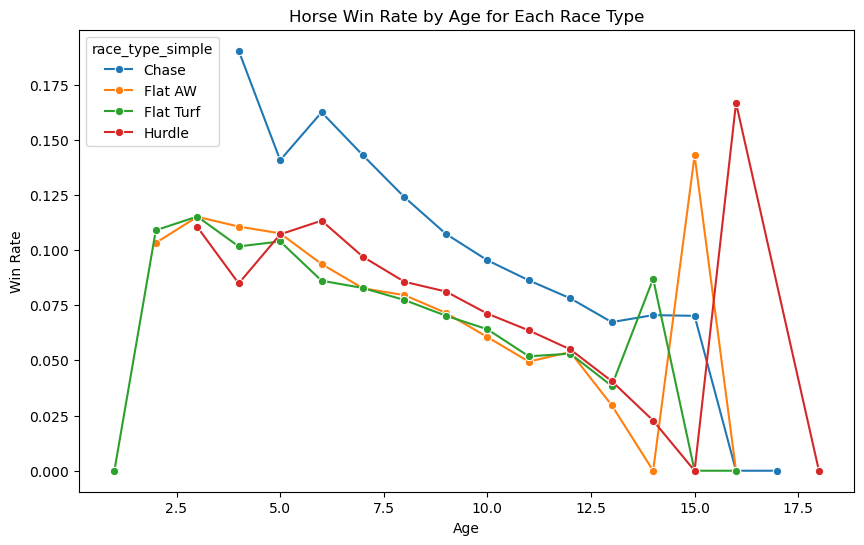

In [99]:
plt.figure(figsize=(10,6))
sns.lineplot(data=win_rates, x="age", y="win_rate", hue="race_type_simple", marker="o")
plt.title("Horse Win Rate by Age for Each Race Type")
plt.ylabel("Win Rate")
plt.xlabel("Age")
plt.show()

As expected, performance in all race types goes down as the horses get older. There are some noticeable spikes at the end beyond age $15$, but this might be caused by lack of data. In addition, I expect that only really good horses continue racing when they get much older, so survivor bias is affecting the data too. We investigate this by looking at the number of races per age per race type:

In [101]:
age_counts = data.groupby(["race_type_simple", "age"])["obs__is_winner"].count().reset_index()
age_counts.rename(columns={"obs__is_winner":"num_races"}, inplace=True)
print(age_counts)

   race_type_simple  age  num_races
0             Chase    4        599
1             Chase    5       4754
2             Chase    6      15121
3             Chase    7      21656
4             Chase    8      19196
5             Chase    9      14490
6             Chase   10      10046
7             Chase   11       5669
8             Chase   12       2931
9             Chase   13       1203
10            Chase   14        312
11            Chase   15         57
12            Chase   16         13
13            Chase   17          3
14          Flat AW    2      24802
15          Flat AW    3      51778
16          Flat AW    4      36675
17          Flat AW    5      23204
18          Flat AW    6      15333
19          Flat AW    7      10466
20          Flat AW    8       6850
21          Flat AW    9       4167
22          Flat AW   10       2113
23          Flat AW   11        809
24          Flat AW   12        316
25          Flat AW   13        101
26          Flat AW   14    

As expected, beyond age $15$ there are very few race counts for all race types.

Interestingly, there are far more older horses in jumping race types (Hurdle, Chase) than in flat race types (Flat Turf, Flat AW). This can be seen for example in the number of $11$ year old horses in each race type. This is especially true for Chase: older horses are much more common.

However, we can also see that in Chase races extremely young horses are far above compared to other race types. Also, horses don't race Chase until they are about $3-4$. We can see that that first peak is unreliable: there are only $599$ races where $4$-year old horses competed in Chase. This not only makes the sample size small, but it is probably also biased: only the horses with great potential will have been considered for the race when they were that young.

By looking at the graph (and discarding the biased peaks on the right and the biased Chase peak on the left), we can clearly see the **peak performance age for each race type**:
- Flat Turf: $3$ years old
- Flat AW: $3$ years old
- Hurdle: $6$ years old
- Chase: $6$ years old

If I had to choose a single **"peak performance age" across all race types**, I would say $5$ is about right (the graph supports this), but looking at it by race makes more sense.

# Q2. Feature Engineering: Rating for each Horse, Jockey and Trainer

In this section we devise new features: scores for each horse, jockey and trainer.

We cannot quite compute the scores yet, as that would cause data leakage from the training set into the test set. In fact, even after we have split the data into training and testing sets, we still **cannot do the preprocessing yet**. This is because later on we will use a technique called Cross-Validation (CV) in order to find the best hyperparameters for our model. In simple terms, in the process of that technique we basically "simulate training on training data and then testing on the testing data". So if we were to compute the scores now, we would introduce data leakage in those "simulations", which would lead to bad choices of hyperparameters. Therefore, in this section we just construct the functions that compute these scores.

It is important to include **only data from previous races, not future races**. This means we can use all data from past races, and only the data from the current race which does not start with "obs_*".

## Horse Rating

Based on the exploration we did into the correlation of the variables in Q0 above, I would like to use:
- From past races: *obs__distance_to_winner*, *obs__top_speed*, *obs__uposition* and *obs_bsp*.
- From the current race: *official_rating*, *age*, *carried_weight*.

The score $S_H$ for a horse $H$ will be:

$$
S_H = \text{official rating}*0.5 - \text{age}*0.1 + \text{carried weight}*0.2 + \text{Past Performance}*0.2
$$

Of course, all four of these features will be standardised so they are on the same scale.

Here the Past Performance is defined as follows:

For each past race $k$, compute a race score $S_k$ as

$$
S_k = \text{observed top speed}*1.3 - \text{observed position}*1.2 - \text{observed distance to winner}*1.3 - \text{observed bsp}*1.2
$$

Of course, all four of those features will also be standardised.

Then we get the Past Performance by adding up all those scores from all those past races, but making sure to weigh each of them based on how recent the race was:

$$
\text{Past Performance} = \frac{\sum_k w_k * S_k}{\sum_k w_k}
$$

Here $w_k$ is the weight for race $k$, which will be $w_k = 1/\text{how many days the race happened prior to the current one}$.

If the horse has not raced before, we will set a Past Performance of $0$. If a past race $k$ has missing values, we will set $S_k=0$. This will just be the mean value across horses (since we will standardise), so it is just a safe value.

Many improvements could be made to this score. For example, everything here is based on linear relationships. But in the interest of time, we just work with this. Here is the function that preprocesses a training dataset by adding the "horse_rating" column:

In [117]:
def compute_horse_ratings(data):
    # Order chronologically and by horse ID
    data = data.sort_values(["horse_id", "race_datetime"]).copy()

    
    # FIRST: PAST PERFORMANCE COMPUTATION
    
    # The columns we will need to compute the Past Performance
    past_cols = ["obs__top_speed", "obs__uposition", "obs__distance_to_winner", "obs__bsp"]
    # We will standardise them, so we initialise columns for that
    for col in past_cols:
        data[col + "_standardised"] = np.nan
    
    # Iterate over each horse's data
    for horse, horse_data in data.groupby("horse_id", sort=False):

        # The indices of the rows for that horse
        idx = horse_data.index

        # For each column needed for the Past Performance we need to standardise
        for col in past_cols:
            # Get the values
            values = horse_data[col].values
            
            # Get the cumulative mean and std up to the current row (we exclude the current row with .shift(1))
            cummean = pd.Series(values).expanding(min_periods=1).mean().shift(1)
            cumstd = pd.Series(values).expanding(min_periods=1).std(ddof=0).shift(1)
            
            # Standardise the values
            z = (values - cummean) / (cumstd + 1e-6)
            # The first row has no past data, so we set it to 0
            z[:1] = 0  
            # If there are no values, fill it with 0 (which is now the mean value after standardising)
            data.loc[idx, col + "_standardised"] = z.fillna(0)
    
    # Compute the score S_k for every race k
    data["s_k"] = (
        +1.3 * data["obs__top_speed_standardised"]
        -1.2 * data["obs__uposition_standardised"]
        -1.3 * data["obs__distance_to_winner_standardised"]
        -1.2 * data["obs__bsp_standardised"]
    )
    
    # We also need the weights based on the days 
    # If the horse has not raced before it sets NaN, but we replace it with a 1 (it is harmless because
    # it is small and allows us to get rid of the NaNs)
    data["prev_race_days"] = data.groupby("horse_id")["race_datetime"].diff().dt.days.fillna(1)
    data["recency_weight"] = 1 / data["prev_race_days"]  
    
    # Compute Past Performance using the weights and the scores S_k
    # Term given by each race
    data["weighted_s"] = data["s_k"] * data["recency_weight"]
    # Cumulative contributions of each race
    data["cumsum_weighted_s"] = data.groupby("horse_id")["weighted_s"].cumsum().shift(1).fillna(0)
    # Cumulative weights
    data["cumsum_weight"] = data.groupby("horse_id")["recency_weight"].cumsum().shift(1).fillna(0)
    # Divide to get Past Performance
    data["past_performance"] = data["cumsum_weighted_s"] / data["cumsum_weight"].replace(0, 1)



    
    # SECOND: FINAL HORSE RATING COMPUTATION
    
    # The columns we will need from the current row
    final_cols = ["official_rating", "age", "carried_weight", "past_performance"]
    # Standardise them
    for col in final_cols:
        mean, std = data[col].mean(), data[col].std() + 1e-6
        data[col + "_standardised"] = (data[col] - mean) / std
    
    # Compute the horse rating
    data["horse_rating"] = (
        0.5 * data["official_rating_standardised"]
        -0.1 * data["age_standardised"]
        +0.2 * data["carried_weight_standardised"]
        +0.2 * data["past_performance_standardised"]
    )

    # Remove the columns we have created along the way except for horse_rating (obviously) and past_performance (since
    # it can be useful as a feature on its own)
    data.drop(["obs__top_speed_standardised", "obs__uposition_standardised", "obs__distance_to_winner_standardised",
       "obs__bsp_standardised", "s_k", "prev_race_days", "recency_weight", "weighted_s", "cumsum_weighted_s", "cumsum_weight", 
       "past_performance_standardised", "official_rating_standardised", "age_standardised", "carried_weight_standardised"], axis=1, inplace=True)
    
    return data

But of course, we will also need to preprocess the test dataset. And that "horse_rating" column should be computed using the past data from the training set and the non-observed data from the current row. Here is the function that preprocesses the test set to produce the horse ratings:

In [119]:
def compute_horse_ratings_test(train_data, test_data):
    # Use a copy to not change the test_data
    test_data_copy = test_data.copy()


    # FIRST: PAST PERFORMANCE FROM TRAINING SET

    # Get the last Past Performance for each horse from the training set
    last_past_perf = train_data.groupby("horse_id")["past_performance"].last()
    test_data_copy["past_performance"] = test_data_copy["horse_id"].map(last_past_perf).fillna(0.0)
    # If the horse is not in the training set, we just set it to 0 



    # SECOND: FINAL HORSE RATING COMPUTATION
    
    # The columns we will need apart from Past Performance
    final_cols = ["official_rating", "age", "carried_weight", "past_performance"]
    
    # Now we want to standardise them
    # To avoid data leakage we use the mean and std from the training set:
    stats = {}
    for col in final_cols:
        mean = train_data[col].mean()
        std = train_data[col].std() + 1e-6
        stats[col] = (mean, std)

    # We can now standardise the test data:
    for col in final_cols:
        mean, std = stats[col]
        test_data_copy[col + "_standardised"] = (test_data_copy[col] - mean) / std

    
    # Finally compute the horse rating
    test_data_copy["horse_rating"] = (
        0.5 * test_data_copy["official_rating_standardised"]
        - 0.1 * test_data_copy["age_standardised"]
        + 0.2 * test_data_copy["carried_weight_standardised"]
        + 0.2 * test_data_copy["past_performance_standardised"]
    )

    # Drop the columns we made along the way except horse_rating and past_performance
    drop_cols = [col + "_standardised" for col in final_cols]
    test_data_copy.drop(drop_cols, axis=1, inplace=True)

    return test_data_copy

## Jockey Rating

We compute the jockey rating as follows: we first compute the win rate from past data. Then we take into account the quality of the horses the jockey has ridden by dividing by the mean horse rating of the horses they have ridden.

**NOTE**: Unfortunately due to time constraints this cannot be implemented. But the reasoning of how to compute the scores is above.

## Trainer Rating

We compute the trainer rating in the same way as the jockey rating: win rate divided by the mean horse rating of the horses the trainer has trained.

**NOTE**: Unfortunately due to time constraints this cannot be implemented. But the reasoning of how to compute the scores is above.

# Q3. Predictive Model

## Train-Test Split

We have to make sure that we avoid data leakage in the train-test split. This can happen in two ways: time (we cannot use future data to predict, so the data in the test set must happen after the training set) and race (data from the training set cannot contain data about a race of a horse which is in the test set). 

We therefore order the data by date, time and race. Then we use roughly the first $75\%$ as training data and the other $25\%$ as test data, making sure that we do not split a race in half:

In [127]:
# Order the data
ordered_data = data.sort_values(by=["race_datetime", "race_id"])

# Compute how much 75% is
length = ordered_data.shape[0]
training_length = int(np.floor(length*0.75))

In [128]:
ordered_data.head()

,racecourse_country,racecourse_name,race_id,race_distance,race_type,race_type_simple,going_clean,n_runners,horse_id,horse_name,...,obs__racing_post_rating,obs__Place,obs__uposition,obs__is_winner,obs__top_speed,obs__distance_to_winner,obs__pos_prize,obs__completion_time,race_datetime,finish_flag
0,GB,Chepstow,49699,2435.0472,Flat,Flat Turf,Good,8,21374,Eton Rambler,...,82.0,3,3,0,48.0,2.5,721.50,155.95,2015-05-01 13:40:00,0
1,GB,Chepstow,49699,2435.0472,Flat,Flat Turf,Good,8,21378,Shades Of Silver,...,81.0,2,2,0,47.0,0.5,1443.75,155.61,2015-05-01 13:40:00,0
2,GB,Chepstow,49699,2435.0472,Flat,Flat Turf,Good,8,26461,Marengo,...,45.0,8,8,0,11.0,23.0,0.00,159.36,2015-05-01 13:40:00,0
3,GB,Chepstow,49699,2435.0472,Flat,Flat Turf,Good,8,50069,Smoker,...,62.0,6,6,0,28.0,13.0,0.00,157.70,2015-05-01 13:40:00,0
4,GB,Chepstow,49699,2435.0472,Flat,Flat Turf,Good,8,102542,Symphony Of Kings,...,77.0,5,5,0,44.0,6.0,0.00,156.53,2015-05-01 13:40:00,0


In [129]:
# Look around that part of the data
ordered_data.iloc[training_length - 5 : training_length + 3]

,racecourse_country,racecourse_name,race_id,race_distance,race_type,race_type_simple,going_clean,n_runners,horse_id,horse_name,...,obs__racing_post_rating,obs__Place,obs__uposition,obs__is_winner,obs__top_speed,obs__distance_to_winner,obs__pos_prize,obs__completion_time,race_datetime,finish_flag
583007,GB,Market Rasen,144382,3332.988,Bumper,Flat Turf,Good,11,84193,Datsalrightgino,...,104.0,3,3,0,65.0,6.75,333.9,246.25,2020-09-26 16:25:00,0
583008,GB,Market Rasen,144382,3332.988,Bumper,Flat Turf,Good,11,138505,Beforeypushdachair,...,NaN,10,10,0,NaN,NaN,0.0,269.00,2020-09-26 16:25:00,1
583009,GB,Market Rasen,144382,3332.988,Bumper,Flat Turf,Good,11,90147,Raiff,...,NaN,11,11,0,NaN,NaN,0.0,271.60,2020-09-26 16:25:00,1
583010,IRE,Listowel,84844,3419.856,Chase,Chase,Soft,8,45950,Mick The Jiver,...,99.0,6,6,0,52.0,37.00,210.0,278.45,2020-09-26 16:30:00,0
583011,IRE,Listowel,84844,3419.856,Chase,Chase,Soft,8,200506,Email Rose,...,NaN,PU,7,0,NaN,NaN,0.0,NaN,2020-09-26 16:30:00,1
583012,IRE,Listowel,84844,3419.856,Chase,Chase,Soft,8,50442,Veneziano Springs,...,NaN,PU,8,0,NaN,NaN,0.0,NaN,2020-09-26 16:30:00,1
583013,IRE,Listowel,84844,3419.856,Chase,Chase,Soft,8,45288,Allardyce,...,109.0,4,4,0,67.0,16.50,840.0,273.32,2020-09-26 16:30:00,0
583014,IRE,Listowel,84844,3419.856,Chase,Chase,Soft,8,42915,Nearly Nama'd,...,105.0,3,3,0,64.0,12.50,1890.0,272.32,2020-09-26 16:30:00,0


We see that at index $583010$ a race ends and another begins. We can therefore split into training and testing there:

In [131]:
training_data = ordered_data.loc[0:583009]
testing_data = ordered_data.loc[583010:]

## Model Choice

Here we discuss various model options and decide on the best one. 

### Horse Level Models

**NOTE**: All the horse-level model options we give below predict a probability of winning for each sample. But they do not ensure that within a single race the probabilities of all the samples in that race add up to $1$. Therefore, in order to use these models for a given race with $H$ many horses, we have to predict the probability $p_h$ of every horse $h$ in that race separately, and then standardise the probabilities $p_1, \cdots, p_H$ like this:

$$
\frac{p_h}{\sum_{j=1}^{j=H}{p_j}}.
$$

**NOTE**: For the first two models the discussion becomes very mathematical and slightly long, but we do not end up using either of them, so it can be skipped without affecting the rest of the report.

- **Logistic Regression**: 

    - Pros: Simple, interpretable.
    - Cons: Clearly rows from the same race or featuring the same horse/jockey/trainer are dependent, but the model actually assumes each sample (row) is independent during training. This is **typical of supervised models: the samples are assumed to be i.i.d**, and that works well in practice. However, in this case the data is so dependent that a fix may be worth it. Here we explain how the model works and where the **independence is assumed** so that we can propose a model that solves this later:
 
    Recall that logistic regression assumes that for sample $i$ with features $x_{1i}, x_{2i}, \cdots, x_{pi}$ and outcome $Y_i$, we have $Y_i \text{ | } x_{1i}, x_{2i}, \cdots, x_{pi} \sim \text{Bernoulli}(p_i)$ and that

  $$
  \text{logit}(p_i) = \log\!\left(\frac{p_i}{1 - p_i}\right) = \beta_0 + \beta_1 * x_{1i} + \cdots + \beta_p * x_{pi} = x_i^\top \beta
  $$

  for some parameters $\beta$. In order to find the optimal parameters, we normally maximise the likelihood (function of parameters that gives probability of observing the data given the parameters) $L(\beta) = p(y_1, \dots, y_N \mid \beta)$. To do so, we normally assume independence of each sample by writing

  $$
  L(\beta) = \prod_{i=1}^N p(y_i \mid \beta).
  $$

  This independence assumption is wrong, since there are various groups (race, horse, jockey, trainer) that cause dependence between samples. The model would probably still perform decently well, but it would be better to solve this.


- **Hierarchical/Mixed-effects Logistic Regression**: This is the upgraded version of the model above. We **solve the independence assumption issue** by adding some random effects. A good introduction can be found here: https://mfviz.com/hierarchical-models/. This is how it works mathematically:

  We now write the same thing but with some extra terms:

  $$
  \text{logit}(p_i) = x_i^\top \beta + u_{\text{race}, i} + u_{\text{horse}, i} + u_{\text{trainer}, i} + u_{\text{jockey}, i}
  $$

  We now have random variables $u_{\text{race}, i} \sim  \mathcal{N}(0, \sigma_{race}^2) 
, u_{\text{horse}, i} \sim  \mathcal{N}(0, \sigma_{horse}^2), u_{\text{trainer}, i} \sim  \mathcal{N}(0, \sigma_{trainer}^2), u_{\text{jockey}, i} \sim  \mathcal{N}(0, \sigma_{jockey}^2)$. Let $u_i$ denote those four random variables, $u$ denote $u_i$ for all $i$, and $\sigma^2$ the four variances (which are the same across samples). Now apart from $\beta$ we have to fit the $\sigma^2$ as well. To do so, we would like to maximise the likelihood $L(\beta, \sigma) = p(y_1, \dots, y_N, u \mid \beta, \sigma^2) = p(y_1, \dots, y_N \mid u, \beta, \sigma^2) \, p(u \mid \beta, \sigma^2)$. In order to do that, we have to rewrite that first term as:

   $$
   p(y_1, \dots, y_N \mid u, \beta, \sigma^2) = \prod_{i=1}^N p(y_i \mid u_i, \beta, \sigma^2).
   $$

    In other words, we have assumed **conditional independence: given the random effects $u$, the samples are independent**. But this is exactly what we want! It is basically saying "If we are given the effect that horse, trainer, race and jockey have, then the rest is independent", which is correct. So this is a good assumption. This replaces the independence assumption of simple logistic regression, which said "samples are completely independent".

  In practice, since $u$ is not observed, we have to maximise the marginal likelihood $ L_m(\beta, \sigma) = p(y_1, \dots, y_N \mid \beta, \sigma)$ (just integrate over $u$):

  $$
  L_m(\beta, \sigma) = \int L(\beta, \sigma) du.
  $$

  Maximising this integral (numerically) gives us the optimal $\beta$ and $\sigma^2$, which we call $\hat{\beta}, \hat{\sigma^2}$. Then when given a new sample $k$, we compute actual values $\hat{u}_{\text{race}, k}, \hat{u}_{\text{horse}, k}, \hat{u}_{\text{trainer}, k}, \hat{u}_{\text{jockey}, k}$ for each of the four random variables by maximising 

  $$
  \hat{u}_k = \arg\max_{u_k}\, p(u_k \mid Y_k, \hat{\beta}, \hat{\sigma}).
  $$

  This is done by using Bayes' theorem to rewrite that expression, and then it becomes completely analytical because we have assumed the distributions of $Y_k$ and $u_k$.


  - Pros: Interpretable, no independence assumption.
  - Cons: Much more expensive computationally. Plus we are already including scores of the horse, trainer and jockey as features, so we do not gain as much with this upgrade compared to the complexity of implementing this model. Even though this is theoretically better, in practice it might be overkill.


- **Binary Classification Neural Network**: This is just a more flexible model than simple logistic regression if we add a final sigmoid layer.
  - Pros: Greater predictive power, captures nonlinearity better.
  - Cons: Less interpretable, still assumes samples are i.i.d.

- **Binary Classification GBM/Random Forest**: Often a good optioon, captures the nonlinear relationships.

  - Pros: Greater predictive power, captures nonlinearity well. Also is functionally very distinct from all the other models on this list, which makes it an interesting candidate.
  - Cons: Less interpretable, still assumes samples are i.i.d.

### Race Level Models

There is an alternative option. Instead of predicting the probability of each row, we could group rows of the same race together into one and predict at the **race level instead of the horse level**.
- **Race-level Multi-Classification**: We can choose some multi-classifier model and represent each horse in a race as a category. The model then predicts the probability of each category (each horse winning). Issue: each race has a different number of horses (categories), so standard models would not work. There are models that account for this, such as the Conditional Logit Model (described here https://www.xlstat.com/solutions/features/conditional-logit-model and here https://grodri.github.io/glms/notes/c6s3). We can upgrade it like we did for logistic regression by using the Hierarchical version of this model too.
   - Pros: No need to standardise the probabilities, since now all the probabilities of a single race add up to $1$.
   - Cons: Computationally expensive.

### Final Decision

Even though the i.i.d. assumption is clearly not true here, it is hard to escape without heavy computation with the Hierarchical model. In real life it would be a good idea to try out all of these models and compare their outcomes. In the interest of time, we will just use a **Horse Level Binary Classification XGBoost and standardise the probabilities within each race**, since it is reasonably fast, is well-supported by existing packages, and is known to be good even when the i.i.d. assumption is violated (see for example https://xgboosting.com/xgboost-assumes-data-is-iid-i.i.d./).

## $T$-fold Rolling Cross-Validation

In order to determine the best hyperparameters for our model, we will use $T$-fold Rolling Cross-Validation. This means that for a specific combination of hyperparameter values, three separate times we will train a model on some data and test it on other data. Each of these three times (called the *folds*) will give us a score of the model's accuracy. Then we take the average of that score. That score reflects how good that combination of hyperparameters is. It effectively simulates how good our model is at generalising.

In order to avoid data leakage (both by time and race), the folds will have a rolling window structure. That is, they will be like (using $T=3$):

- Fold $1$: train on races $1-500$ and test on $501-600$. 
- Fold $2$: train on races $1-600$ and test on $601-700$.
- Fold $3$: train on races $1-700$ and test on $701-800$.

(The numbers are not real, it is just to illustrate).

For all of this, we use the training data. In each fold, the data used to train the model is also called the training data (of that fold), while the data used to test it is called the validation data.

In each of the folds, we will need to preprocess the data before we fit the model as well as **delete the features we cannot use for prediction** (the *obs_* columns and the target itself). Note that we **cannot preprocess the data all at once before CV, we have to do it inside each fold**, as there would be data leakage inside the folds.

I will find good splitting points that don't cut through a race (to avoid data leakage from that race), and then do the cross-validation.

In [142]:
print(f"There are {training_data.shape[0]} training samples")

There are 583010 training samples


I have checked the data, and found good splitting points for the three folds: indices $250000$, $399999$, and $499995$. 

In [144]:
fold_split_idx = [250000, 399999, 499995]

Now we can write the function that tests a single combination of hyperparameters via CV and returns the score. For the score, we use the **cross-entropy loss**. It is a common metric in these kinds of betting problems that measures how good the predicted probabilities are and which we want to minimise:

$$
\text{Cross-Entropy Loss} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(p_i) + (1 - y_i)\log(1 - p_i) \right].
$$

In [147]:
def CV(data, fold_split_idx, hyperparams):

    # Keep lists that stores the T scores 
    celoss_scores = []
    
    # Do T folds
    for i, idx in enumerate(fold_split_idx):

        # Get the training and validation data for that fold
        train_data = data.loc[0:idx].copy()
        # Find the last row of the validation set
        if i < len(fold_split_idx)-1:
            end_val = fold_split_idx[i+1]
        else:
            end_val = len(data)
        val_data = data.loc[idx+1:end_val-1].copy()
        #print(f"Doing testing from {idx} to {end_val}")

        # Get the horse_rating and past_performance features for the training and validation data
        train_data = compute_horse_ratings(train_data)
        val_data = compute_horse_ratings_test(train_data, val_data)

        # Preprocess the categorical columns:
        # Country
        preprocess_country(train_data)
        preprocess_country(val_data)
        # Race course name
        val_data = preprocess_racecourse(train_data, new_data=val_data, new_flag=True)
        train_data = preprocess_racecourse(train_data, new_data=None, new_flag=False)
        # Race type and race type simple
        preprocess_race_type(train_data)
        preprocess_race_type(val_data)
        # Going clean
        preprocess_going(train_data)
        preprocess_going(val_data)
        # Horse name, Jockey name, Trainer name
        for col_name in ["horse_name", "jockey_name", "trainer_name"]:
            val_data = preprocess_names(train_data, col_name, new_data=val_data, new_flag=True)
            train_data = preprocess_names(train_data, col_name, new_data=None, new_flag=False)


        # Drop the columns we cannot/should not use to fit the model (obs_, finish_flag and the IDs)
        drop_cols = ["obs__bsp", "finish_flag", "obs__racing_post_rating", "obs__Place", "obs__uposition", "obs__top_speed", "obs__distance_to_winner",
       "obs__pos_prize", "obs__completion_time", "race_datetime", "horse_id", "trainer_id", "race_id", "jockey_id"]
        # We keep the race_id from the validation data for later
        val_race_id = val_data["race_id"].reset_index(drop=True).copy()
        # Drop the columns
        train_data.drop(drop_cols, axis=1, inplace=True)
        val_data.drop(drop_cols, axis=1, inplace=True)

        


        # Split into features and target
        X_train = train_data.drop("obs__is_winner", axis=1)
        y_train = train_data["obs__is_winner"]
        X_val = val_data.drop("obs__is_winner", axis=1)
        y_val = val_data["obs__is_winner"]



        # Initialise the model
        model = XGBClassifier(objective="binary:logistic",**hyperparams)

        # Train the model
        model.fit(X_train, y_train, verbose=False)


        # Predict probabilities on the validation set
        y_prob_raw = model.predict_proba(X_val)[:, 1]

        # Normalise the probabilities within each race
        val_temporary = val_data.reset_index(drop=True).copy()
        # Rejoin the race_id column so we can use it
        val_temporary["race_id"] = val_race_id
        # Add as a column
        val_temporary["y_prob_raw"] = y_prob_raw
        # Group by race and add up all the probabilities
        sum_by_race = val_temporary.groupby("race_id")["y_prob_raw"].transform("sum")
        # Divide each probability of each race by the corresponding race-level sum
        # to get the final probabilities
        y_prob = val_temporary["y_prob_raw"] / sum_by_race
        

        
        # Compute cross-entropy loss and store it
        # We make sure none of the probabilities are exactly 0 or 1 by
        # clipping them, since log(0) or log(1) would give us problems
        celoss_score = log_loss(y_val, np.clip(y_prob, 1e-15, 1 - 1e-15))
        celoss_scores.append(celoss_score)




    # Compute average score over the folds 
    avg_celoss_score = sum(celoss_scores)/len(celoss_scores)

    return avg_celoss_score

Now that we have a way to score a hyperparameter combination, we can just search over possible combinations. Here we only try three combinations due to time constraints, but it would be better to test many more:

In [149]:
# Hyperparameter combinations to try
hyperparam_grid = [
    {"max_depth": 4, "learning_rate": 0.05, "n_estimators": 200, "subsample": 0.8, "colsample_bytree": 0.8},
    {"max_depth": 6, "learning_rate": 0.05, "n_estimators": 300, "subsample": 0.8, "colsample_bytree": 0.8},
    {"max_depth": 6, "learning_rate": 0.1,  "n_estimators": 400, "subsample": 0.8, "colsample_bytree": 0.9},
]


# Function that searches over combinations
def hyperparam_search(data, fold_split_idx, hyperparam_grid):
    # Initialise best score and parameters
    best_score = np.inf
    best_params = None

    # Loop through all hyperparameter combinations
    for params in hyperparam_grid:
        print("Testing hyperparameters:", params)

        # Get the CV score
        cv_score = CV(data, fold_split_idx, params)
        print(f"CV Score: {cv_score} \n")

        # Keep track of the best combination (lowest cross-entropy)
        if cv_score < best_score:
            best_score = cv_score
            best_params = params
    
    return best_params, best_score

In [150]:
# Find the best hyperparameters
best_params, best_score = hyperparam_search(training_data, fold_split_idx, hyperparam_grid)
print(f"The best score is: {best_score}")
print(f"They correspond to parameters: {best_params}")

Testing hyperparameters: {'max_depth': 4, 'learning_rate': 0.05, 'n_estimators': 200, 'subsample': 0.8, 'colsample_bytree': 0.8}
CV Score: 0.2770470887614169 

Testing hyperparameters: {'max_depth': 6, 'learning_rate': 0.05, 'n_estimators': 300, 'subsample': 0.8, 'colsample_bytree': 0.8}
CV Score: 0.2775038774546323 

Testing hyperparameters: {'max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 400, 'subsample': 0.8, 'colsample_bytree': 0.9}
CV Score: 0.27939917110314755 

The best score is: 0.2770470887614169
They correspond to parameters: {'max_depth': 4, 'learning_rate': 0.05, 'n_estimators': 200, 'subsample': 0.8, 'colsample_bytree': 0.8}


## Fitting the Model

Now that we have found the best hyperparameters, we can construct our model with them. We create a function that preprocesses the data, fits the model, standardises the within-race probabilities, and returns these probabilities:

In [153]:
def predict(training_data, testing_data, best_params):
    # Get the horse_rating and past_performance features for the training and testing data
    training_data = compute_horse_ratings(training_data)
    testing_data = compute_horse_ratings_test(training_data, testing_data)

    # Preprocess the categorical columns:
    # Country
    preprocess_country(training_data)
    preprocess_country(testing_data)
    # Race course name
    testing_data = preprocess_racecourse(training_data, new_data=testing_data, new_flag=True)
    training_data = preprocess_racecourse(training_data, new_data=None, new_flag=False)
    # Race type and race type simple
    preprocess_race_type(training_data)
    preprocess_race_type(testing_data)
    # Going clean
    preprocess_going(training_data)
    preprocess_going(testing_data)
    # Horse name, Jockey name, Trainer name
    for col_name in ["horse_name", "jockey_name", "trainer_name"]:
        testing_data = preprocess_names(training_data, col_name, new_data=testing_data, new_flag=True)
        training_data = preprocess_names(training_data, col_name, new_data=None, new_flag=False)


    # Drop the columns we cannot/should not use to fit the model (obs_, finish_flag and the IDs)
    drop_cols = ["obs__bsp", "finish_flag", "obs__racing_post_rating", "obs__Place", "obs__uposition", "obs__top_speed", "obs__distance_to_winner",
    "obs__pos_prize", "obs__completion_time", "race_datetime", "horse_id", "trainer_id", "race_id", "jockey_id"]
    # We keep the race_id for later
    test_race_id = testing_data["race_id"].reset_index(drop=True).copy()
    # Drop the columns
    training_data.drop(drop_cols, axis=1, inplace=True)
    testing_data.drop(drop_cols, axis=1, inplace=True)

    # Divide the training data into features and target
    X_training = training_data.drop("obs__is_winner", axis=1)
    y_training = training_data["obs__is_winner"]

    # Divide the testing data into features and target
    X_testing = testing_data.drop("obs__is_winner", axis=1)
    y_testing = testing_data["obs__is_winner"]

    # Initialise the model with the best hyperparameters
    model = XGBClassifier(objective="binary:logistic", **best_params)

    # Train the model on the training data
    model.fit(X_training, y_training, verbose=False)

    # Predict raw probabilities
    y_prob_raw = model.predict_proba(X_testing)[:, 1]

    # Normalise the probabilities within each race
    X_testing_temporary = X_testing.reset_index(drop=True).copy()
    # Rejoin with test_race_id so we can use it
    X_testing_temporary["race_id"] = test_race_id
    # Add as a column
    X_testing_temporary["y_prob_raw"] = y_prob_raw
    # Group by race and add up all the probabilities
    sum_by_race = X_testing_temporary.groupby("race_id")["y_prob_raw"].transform("sum")
    # Divide each probability of each race by the corresponding race-level sum
    # to get the final probabilities
    y_prob = X_testing_temporary["y_prob_raw"] / sum_by_race

    return y_prob

# Q4. Compare to the Betting Market & Finding a Strategy

## Compare to the Betting Market

### Overall Comparison

Get our predicted probabilities:

In [159]:
# Reset index so they match
our_probabilities = predict(training_data, testing_data, best_params).reset_index(drop=True)
testing_data = testing_data.reset_index(drop=True)

# Assign as a column
testing_data["our_probabilities"] = our_probabilities

Get the cross-entropy score for our probabilities:

In [161]:
celoss_our = log_loss(testing_data["obs__is_winner"], our_probabilities)
print("The cross-entropy loss for our predictions on the whole testing data is: ", celoss_our)
print("The cross-entropy loss score from CV was: ", best_score)

The cross-entropy loss for our predictions on the whole testing data is:  0.3429359996545031
The cross-entropy loss score from CV was:  0.2770470887614169


This score is substantially higher than the earlier score we got for CV. This is not good and suggests that the model is overfitting and/or something else is affecting it. I have a hypothesis:

**COVID**: The effect of COVID disrupted many races and made things in that time period harder to predict with only past data. We can check that the training data has $583$k samples, out of which the last $83$k are from $2020$ (when COVID began). The test set is entirely contained between $2020$ and $2022$. Our model was not trained on COVID data nearly enough. 
In addition, when doing the three folds in cross-validation, we only tested on COVID-era data in the third fold (the only fold whose validation set included rows from that last $83$k rows). This means that hyperparameter selection did not take COVID into account as much as it should have.

That would explain why the model performs so much worse on the testing set compared to the cross-validation.

Now we get the market's predicted probabilities from *obs__bsp*. Note that we **can only use the data where *obs__bsp* is not missing**:

In [164]:
# There are some rows with missing obs__bsp, so we remove those
testing_data = testing_data[testing_data["obs__bsp"].notnull()].reset_index(drop=True)

# Compute probabilities
betfair_probs = 1 / testing_data["obs__bsp"]

# Clip the probabilities to avoid 0 or 1
betfair_probs = np.clip(betfair_probs, 1e-15, 1 - 1e-15)

# Assign as a column
testing_data["betfair_probs"] = betfair_probs

But we cannot compare the market's loss here and our loss on the whole data (which we computed at the start). We would be testing the predictions on different test sets. To **fairly compare our predictions vs the market's**, we should test our probabilities in the same dataset as we tested the market's probabilities (on that data where *obs__bsp* is not missing):

In [166]:
celoss_our_notmissing = log_loss(testing_data["obs__is_winner"], testing_data["our_probabilities"])
celoss_betfair = log_loss(testing_data["obs__is_winner"], testing_data["betfair_probs"])
print("Our cross-entropy loss on all the data was:", celoss_our)
print("Our cross-entropy loss on only the data with non-missing market prediction:", celoss_our_notmissing)
print("Betfair cross-entropy loss:", celoss_betfair)

Our cross-entropy loss on all the data was: 0.3429359996545031
Our cross-entropy loss on only the data with non-missing market prediction: 0.38737700292141886
Betfair cross-entropy loss: 0.31780019610221955


Our model performs worse on that data than on the whole test set. And either way, the market beats the model. I have a hypothesis:

**Different training and testing distributions**: When we trained the model, we trained it on data that contained samples with missing *obs__bsp* values. That is the training data distribution. Those missing values were rows which were probably hard for the market to predict. However, when we only test it on data without those kinds of rows, we are testing on a different distribution. Furthermore, those rows we got rid of were probably especially hard for the market to predict, while it might have been easier for our model to predict.


This reason disproportionately (and negatively) affects our model's performance, but since comparison on that data is the only fair way to do it, we will use those scores. Note that it would be senseless to not train on those rows by removing them at the start, since in real life we wouldn't be able to preemptively remove such rows (because we don't have access to obs__bsp). So in summary, **our model does not beat the market overall** with final scores of:

In [168]:
print("Our cross-entropy loss:", celoss_our_notmissing)
print("Betfair cross-entropy loss:", celoss_betfair)

Our cross-entropy loss: 0.38737700292141886
Betfair cross-entropy loss: 0.31780019610221955


### Comparison by Subsets

Even though our model does not beat the market overall, it might do so in some subsets. In the interest of time, we will only consider subsets of race type (*race_type_simple*), racecourse going (*going_clean*) and number of runners (*n_runners*). However, other subsets could be considered, such as racecourse name, horse age, time period, etc.

We start with race type:

In [172]:
# Store the results for each race type
results = []

# Loop over all race types
for race_type, race_type_data in testing_data.groupby("race_type_simple"):

    # Compute scores for our predictions and the market's predictions
    our_score = log_loss(race_type_data["obs__is_winner"], race_type_data["our_probabilities"])
    market_score = log_loss(race_type_data["obs__is_winner"], race_type_data["betfair_probs"])
    # Take the difference (positive is good)
    diff = market_score - our_score  

    # Store the results for this race type
    results.append({
        "race_type_simple": race_type,
        "n_samples": len(race_type_data),
        "our_loss": our_score,
        "market_loss": market_score,
        "diff": diff
    })

# Put results into a DataFrame
racetype_results_df = pd.DataFrame(results).sort_values("diff", ascending=False)

Similarly for the racecourse going:

In [174]:
# Store the results for each going type
results = []

# Loop over all going types
for going_clean, going_clean_data in testing_data.groupby("going_clean"):

    # Compute scores for our predictions and the market's predictions
    our_score = log_loss(going_clean_data["obs__is_winner"], going_clean_data["our_probabilities"])
    market_score = log_loss(going_clean_data["obs__is_winner"], going_clean_data["betfair_probs"])
    # Take the difference (positive is good)
    diff = market_score - our_score  

    # Store the results for this going type
    results.append({
        "going_clean": going_clean,
        "n_samples": len(going_clean_data),
        "our_loss": our_score,
        "market_loss": market_score,
        "diff": diff
    })

# Put results into a DataFrame and print
going_results_df = pd.DataFrame(results).sort_values("diff", ascending=False)

Now with number of runners:

In [176]:
# Store the results for each number of runners
results = []

# Loop over all number of runners
for n_runners, n_runners_data in testing_data.groupby("n_runners"):

    # Compute scores for our predictions and the market's predictions
    our_score = log_loss(n_runners_data["obs__is_winner"], n_runners_data["our_probabilities"])
    market_score = log_loss(n_runners_data["obs__is_winner"], n_runners_data["betfair_probs"])
    # Take the difference (positive is good)
    diff = market_score - our_score  

    # Store the results for this number of runners
    results.append({
        "n_runners": n_runners,
        "n_samples": len(n_runners_data),
        "our_loss": our_score,
        "market_loss": market_score,
        "diff": diff
    })

# Put results into a DataFrame and print
nrunners_results_df = pd.DataFrame(results).sort_values("diff", ascending=False)

Now we look at the results:

In [178]:
print("Race type: ")
print(racetype_results_df)

Race type: 
  race_type_simple  n_samples  our_loss  market_loss      diff
0            Chase      24744  0.386319     0.340231 -0.046088
2        Flat Turf      55156  0.377882     0.314101 -0.063781
1          Flat AW      43781  0.390156     0.318248 -0.071908
3           Hurdle      41309  0.397743     0.308829 -0.088914


In [179]:
print("Going clean: ")
print(going_results_df)

Going clean: 
  going_clean  n_samples  our_loss  market_loss      diff
0        Firm      13870  0.399723     0.339345 -0.060378
1        Good     104977  0.387229     0.319048 -0.068181
3        Soft      33298  0.376957     0.305794 -0.071162
2       Heavy      12845  0.402271     0.315464 -0.086807


In [180]:
print("Number of runners :")
print(nrunners_results_df)

Number of runners :
    n_runners  n_samples  our_loss  market_loss          diff
27         29         50  0.143056     0.156890  1.383491e-02
25         27        143  0.212061     0.212062  9.431266e-07
2           4       3195  0.489413     0.483263 -6.149487e-03
0           2         94  0.623121     0.609885 -1.323556e-02
28         30         65  0.192628     0.175356 -1.727216e-02
21         23        374  0.232402     0.212427 -1.997511e-02
26         28        101  0.161564     0.139458 -2.210614e-02
19         21        533  0.234296     0.211236 -2.305998e-02
22         24        313  0.230019     0.201224 -2.879492e-02
4           6      10414  0.447934     0.407194 -4.073966e-02
3           5       6700  0.493316     0.445065 -4.825141e-02
24         26        171  0.232092     0.173977 -5.811591e-02
14         16       5270  0.313054     0.253707 -5.934659e-02
29         32         21  0.219879     0.160344 -5.953497e-02
15         17       2797  0.300710     0.238976 -6

We can clearly see that **the market beats the model in every subset**. The only exceptions are races with $29$ or $27$ runners, but the amount of samples for each subset ($50$ and $143$) is too low to meaningfully consider that our model beats the market there. We do see that in some subsets of races which are more unpredictable/noisy, our model performs closer to the market (e.g. in Chase races).

It would be interesting to see if these results also hold if we used our model to predict non-COVID-era races. I suspect it would do better, but perhaps not as well as the market.

## Strategy

Since our model does not have a niche where it outperforms the market, **there is no safe strategy that wins in the long term**. The expected return would be negative even if we assume that there is no commission.

Part of our model's poor performance could be attributed to lack of real-time data. If the model could intake things like current weather (or any weather measurement in the past data would also be good), it might perform better. It would also help to include the ratings for each trainer and jockey from Q2 (which was not possible due to time constraints). It would be interesting to **compare this model to a race-level model** to see if there is a benefit to encasing the requirement of all probabilities adding up to $1$ within each race inside the model, instead of just standardising after the model's predictions.

## Assessing Statistical Significance

I believe that it is pretty clear that our model performs worse than the market, since the scores were computed on hundreds of thousands of samples. However, we can also do a **t-test** as a sanity check:

Our null hypothesis is that the average loss (across all races) of our model is equal to the market's average loss. The alternate hypothesis is that the model performs worse than the market. We can get the $p$-value, which is just the probability that we'd see the difference in model and market losses assuming that the null hypothesis is true. If $p<0.05$, that means that our observation was very rare, which gives evidence for the alternate hypothesis. We compute the $p$-value here:

In [186]:
# Get the unique races
race_ids = testing_data["race_id"].unique()

# Store the loss for our model and the market for each race
model_losses = []
market_losses = []

# Loop through the races
for race_id in race_ids:
    # Get the data for that race
    race = testing_data[testing_data["race_id"] == race_id]
    
    # Skip races with missing values
    if race["our_probabilities"].isna().any() or race["betfair_probs"].isna().any():
        continue

    # Skip races which have no winner or only winners for some reason
    # (both 0s and 1s are needed to compute the loss!)
    if race["obs__is_winner"].nunique() < 2:
        continue

    # Store the loss of the model
    model_losses.append(log_loss(race["obs__is_winner"], race["our_probabilities"]))
    # Store the loss of the market
    market_losses.append(log_loss(race["obs__is_winner"], race["betfair_probs"]))

# Get the p_value
_, p_value = stats.ttest_rel(model_losses, market_losses)
print(f"P-value: {p_value}")

P-value: 0.0


As expected, the $p$-value is extremely small.